In [57]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch import nn, optim
from dataset import CXRMulitmodalDataset
from model import CheXagentSigLIPBinary
from transformers import AutoModel, AutoProcessor, AutoConfig

In [58]:
MODEL_NAME = "StanfordAIMI/XraySigLIP__vit-l-16-siglip-384__webli"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
dtype = torch.float32

In [59]:
config = AutoConfig.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True
)
vision_full = AutoModel.from_pretrained(
    MODEL_NAME,
    config=config,
    trust_remote_code=True
).to(device, dtype)
vision_encoder = vision_full.vision_model
del vision_full

/home/jupyter-nafisha/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [77]:
checkpoint_path= '/home/jupyter-nafisha/chexAgent-Normal-Abnormal/checkpoints/best_model.pth'
model = CheXagentSigLIPBinary(vision_encoder= vision_encoder)
ckpt = torch.load(checkpoint_path, map_location="cpu")
model.load_state_dict(ckpt)
model.to(device)
model.eval()

CheXagentSigLIPBinary(
  (vision_encoder): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(1024, 1024)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-23): 24 x SiglipEncoderLayer(
          (self_attn): SiglipAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_fe

In [78]:
# ckpt.keys()

In [79]:
# Total parameters
total_params = sum(p.numel() for p in model.parameters())

# Trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 317,008,417
Trainable parameters: 317,008,417


In [80]:
# test_csv = '/home/jupyter-nafisha/X-ray-covariates/CSVs/test.csv'
# img_dir = '/home/common/data_v3'

# padchest
test_csv = '/home/jupyter-nafisha/X-ray-covariates/CSVs/PADCHEST_selected_with_reports.csv'
img_dir = '/home/jupyter-nafisha/X-ray-covariates/padchest_normalized'

In [81]:
# data = pd.read_csv(test_csv)
# len(data)

In [82]:
test_dataset = CXRMulitmodalDataset(test_csv, img_dir, transform=None)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=8)

In [83]:
len(test_dataset)/4

399.75

In [84]:
true_labels = test_dataset.df["label"].map({"Normal": 0, "Abnormal": 1}).tolist()
image_names = test_dataset.df["image_id"].tolist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


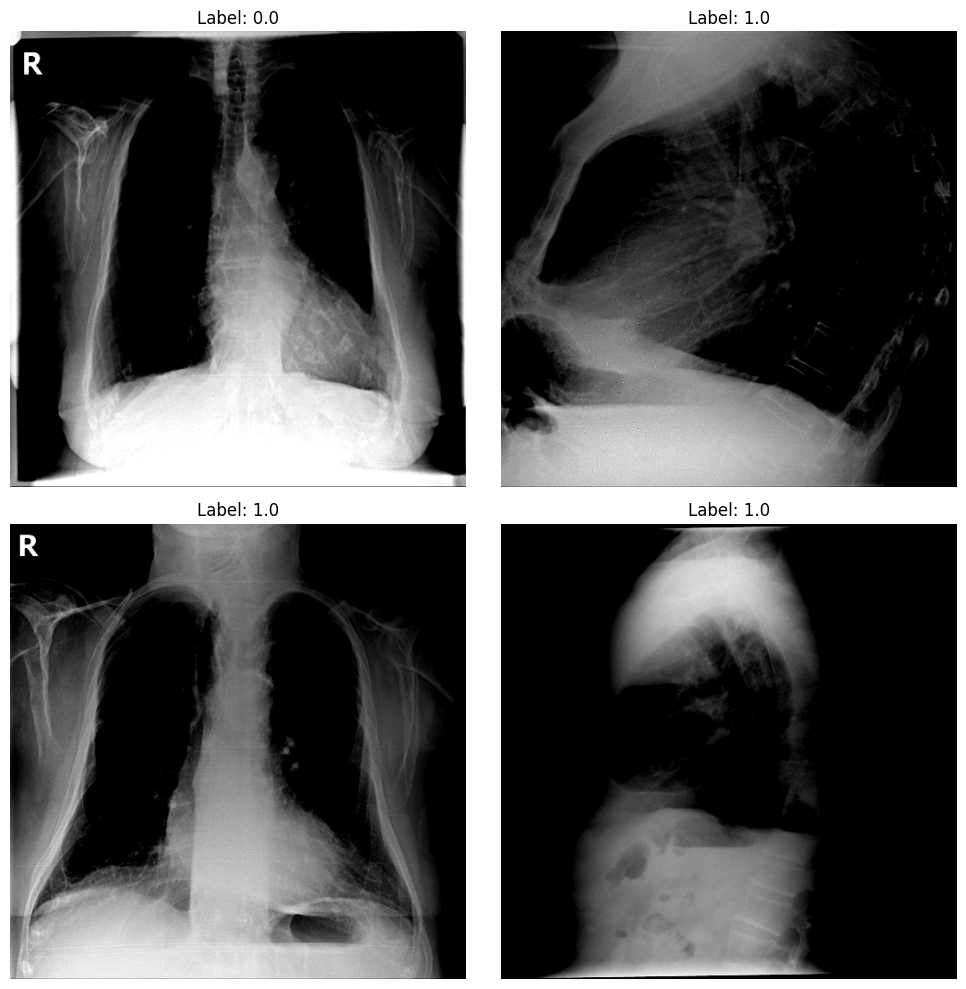

In [85]:
import matplotlib.pyplot as plt
import torch

# Get one batch
for images, view, sex, label in test_loader:
    break  # only take the first batch

# If images are normalized, unnormalize them (optional but common)
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img * std + mean

# images = unnormalize(images)

# Plot 16 images in a 4x4 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i in range(4):
    img = images[i].permute(1, 2, 0)  # C,H,W → H,W,C
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Label: {label[i].item()}")

plt.tight_layout()
plt.show()

In [86]:
images.shape, view.shape, sex.shape, label.shape

(torch.Size([4, 3, 512, 512]),
 torch.Size([4]),
 torch.Size([4]),
 torch.Size([4]))

In [87]:
view, sex

(tensor([0, 2, 0, 2]), tensor([1, 0, 0, 0]))

In [88]:
predictions = []
count = 0
with torch.no_grad():
    for images, view, sex, label in test_loader:  
        images = images.to(device)
        view = view.to(device)
        sex = sex.to(device)
        label = label.to(device)

        _, logits = model(images, view, sex)             # shape: (B, 1)
        probs = torch.sigmoid(logits).squeeze(1)      # shape: (B,)

        preds = (probs >= 0.5).long()      # thresholding for binary prediction

        predictions.extend(preds.cpu().numpy().tolist())

        if count%100==0:
            print("step:- ", count)
        count+=1

step:-  0
step:-  100
step:-  200
step:-  300


In [89]:
acc = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
cm = confusion_matrix(true_labels, predictions)

tn, fp, fn, tp = cm.ravel()
# Specificity
specificity = tn / (tn + fp)

In [90]:
print("\n==== Evaluation Metrics ====")
print(f"Accuracy     :  {acc:.4f}")
print(f"Precision    :  {precision:.4f}")
print(f"Recall       :  {recall:.4f}")
print(f"Specificity  :  {specificity:.4f}")
print(f"F1 Score     :  {f1:.4f}")
print("\nConfusion Matrix:")
print(cm)


==== Evaluation Metrics ====
Accuracy     :  0.7586
Precision    :  0.8671
Recall       :  0.5307
Specificity  :  0.9365
F1 Score     :  0.6584

Confusion Matrix:
[[841  57]
 [329 372]]


In [91]:
df = pd.DataFrame({
    "image_name": image_names,
    "true_label": true_labels,
    "predicted_label": predictions
})

# df.to_csv("test_predictions_orig_test.csv", index=False)

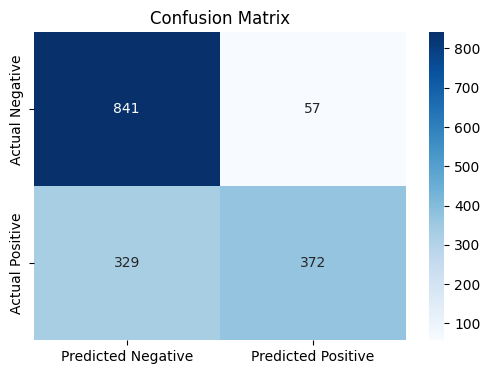

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrix
cm = np.array([[tn, fp],
               [fn, tp]])

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.title("Confusion Matrix")
plt.show()

In [76]:
835+63+324+377

1599

# Single file inference

In [18]:
# combining csvs

import pandas as pd
orig_csv = '/home/jupyter-nafisha/X-ray-covariates/CSVs/test.csv'
inf_csv = '/home/jupyter-nafisha/chexAgent-Normal-Abnormal/main/test_predictions_orig_test.csv'

orig_data = pd.read_csv(orig_csv)
inf_data = pd.read_csv(inf_csv)

In [5]:
# inf_data

In [19]:
inf_data_combined = orig_data.merge(
    inf_data,
    left_on = 'image_id',
    right_on = 'image_name',
    how= 'inner'
)

In [21]:
inf_data_combined = inf_data_combined[['image_id', 'sex', 'orientation', 'class_name', 'label', 'true_label', 'predicted_label']]

In [22]:
# inf_data_combined

In [23]:
import torch
# import pandas as pd
# from torch.utils.data import DataLoader
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# from torch import nn, optim
# from dataset import CXRMulitmodalDataset
from model import CheXagentSigLIPBinary
from transformers import AutoModel, AutoProcessor, AutoConfig

In [24]:
MODEL_NAME = "StanfordAIMI/XraySigLIP__vit-l-16-siglip-384__webli"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
dtype = torch.float32

In [25]:
config = AutoConfig.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True
)
vision_full = AutoModel.from_pretrained(
    MODEL_NAME,
    config=config,
    trust_remote_code=True
).to(device, dtype)
vision_encoder = vision_full.vision_model
del vision_full

/home/jupyter-nafisha/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [26]:
checkpoint_path= '/home/jupyter-nafisha/chexAgent-Normal-Abnormal/main/best_model.pth'
model = CheXagentSigLIPBinary(vision_encoder= vision_encoder)
ckpt = torch.load(checkpoint_path, map_location="cpu", weights_only= False)
model.load_state_dict(ckpt)
model.to(device)
model.eval()

CheXagentSigLIPBinary(
  (vision_encoder): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(1024, 1024)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-23): 24 x SiglipEncoderLayer(
          (self_attn): SiglipAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_fe

In [27]:
# import pandas as pd
# test_csv = '/home/jupyter-nafisha/X-ray-covariates/CSVs/test.csv'
# data= pd.read_csv(test_csv)
# data

In [28]:
def encode_view(orientation):
    # 0: PA, 1: AP, 2: Lateral
    if orientation == "lateral":
        return 2
    if orientation == "PA":
        return 0
    return 1

def encode_sex(sex):
    return 0 if sex == "M" else 1

In [29]:
from transformers import AutoModel, AutoProcessor, AutoConfig

MODEL_NAME = "StanfordAIMI/XraySigLIP__vit-l-16-siglip-384__webli"

processor = AutoProcessor.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True
)

In [65]:
TP = inf_data_combined[inf_data_combined['true_label']==inf_data_combined['predicted_label']]
TP = TP[TP['true_label']==1]

In [66]:
TP

,image_id,sex,orientation,class_name,label,true_label,predicted_label
0,chexpert/patient20327/study1/view2_lateral.jpg,M,lateral,"Lung Opacity, Lung Lesion, Atelectasis, Pleura...",Abnormal,1,1
2,vinbig/5f4eff3b76151906fe87be784d191a1f.jpg,F,PA,"Aortic enlargement, Cardiomegaly, Pleural thic...",Abnormal,1,1
3,chexpert/patient41165/study9/view1_frontal.jpg,M,AP,"Lung Opacity, Pleural Effusion",Abnormal,1,1
4,chexpert/patient16357/study1/view1_frontal.jpg,M,PA,"Cardiomegaly, Lung Opacity, Lung Lesion, Pleur...",Abnormal,1,1
6,chexpert/patient51361/study1/view1_frontal.jpg,M,AP,"Atelectasis, Pleural Effusion",Abnormal,1,1
...,...,...,...,...,...,...,...
7153,vinbig/e31be972e181987a8600a8700c1ebe88.jpg,F,PA,"Aortic enlargement, Calcification, Cardiomegal...",Abnormal,1,1
7155,chexpert/patient07706/study1/view1_frontal.jpg,F,PA,Lung Opacity,Abnormal,1,1
7158,chexpert/patient28207/study9/view2_lateral.jpg,M,lateral,"Cardiomegaly, Lung Opacity, Pleural Effusion",Abnormal,1,1
7159,chexpert/patient30795/study2/view2_lateral.jpg,M,lateral,Lung Opacity,Abnormal,1,1


In [67]:
import os
import random
x = random.randint(0, 2977)
print(x)
dir_path = '/home/common/data_v3'
row = TP.iloc[x]
# print(row)
img_path = os.path.join(dir_path, row['image_id'])

view = row['orientation']
sex = row['sex']

view = encode_view(row['orientation'])
sex = encode_sex(row['sex'])

view = torch.tensor(view, dtype=torch.long)
sex = torch.tensor(sex, dtype=torch.long)

label = 0 if row['label'] == 'Normal' else 1
label = torch.tensor(label, dtype=torch.float32)

print(img_path, view, sex, label)

582
/home/common/data_v3/chexpert/patient05090/study2/view1_frontal.jpg tensor(1) tensor(0) tensor(1.)


In [68]:
from PIL import Image
image = Image.open(img_path).convert("RGB")

inputs = processor(
    images=image,
    return_tensors="pt"
)

pixel_values = inputs['pixel_values']

In [69]:
img_path

'/home/common/data_v3/chexpert/patient05090/study2/view1_frontal.jpg'

In [70]:
# import numpy as np
# pixel_values.shape
# np.unique(pixel_values)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


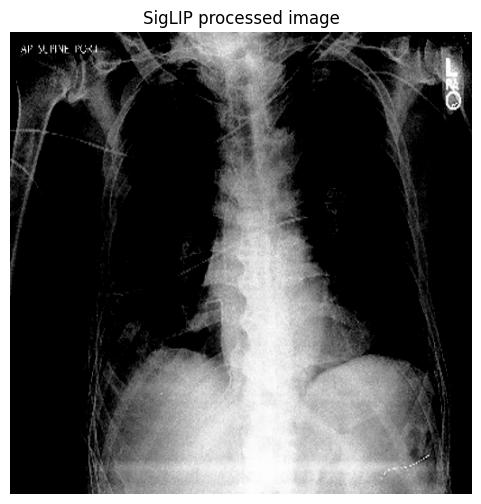

In [71]:
import matplotlib.pyplot as plt
import torch

img = pixel_values.squeeze(0)      
img = img.permute(1, 2, 0)         

img = img.detach().cpu().numpy()

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title("SigLIP processed image")
plt.show()


In [72]:
pixel_values = pixel_values.to(device)
view = view.unsqueeze(0).to(device)
sex = sex.unsqueeze(0).to(device)
attention, output = model(pixel_values, view, sex)

In [73]:
preds = torch.sigmoid(output)
preds = (preds > 0.5).float()

In [74]:
preds, label

(tensor([[1.]], device='cuda:0'), tensor(1.))

In [75]:
# print(len(attention))
# for i in range(len(attention)):
#     print(attention[i].shape)

In [76]:
import torch

# Step 1: average heads
attn = torch.stack(attention).mean(dim=2)  # (24, B, 1024, 1024)
attn = attn.squeeze(1)                      # (24, 1024, 1024)

# Step 2: add identity (residual)
I = torch.eye(attn.size(-1)).to(attn.device)
attn = attn + I
attn = attn / attn.sum(dim=-1, keepdim=True)

# Step 3: rollout
rollout = attn[0]
for i in range(1, attn.size(0)):
    rollout = attn[i] @ rollout

# Step 4: global importance
importance = rollout.mean(dim=0)  # (1024,)

In [77]:
importance_map = importance.reshape(32, 32)
importance_map = importance_map / importance_map.max()

In [78]:
importance_map = torch.nn.functional.interpolate(
    importance_map.unsqueeze(0).unsqueeze(0),
    size=(512, 512),
    mode='bilinear',
    align_corners=False
).squeeze()

In [79]:
import numpy as np

img = pixel_values.squeeze(0).permute(1, 2, 0).cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())


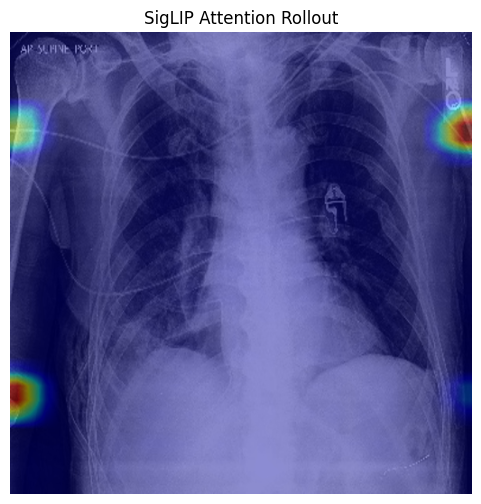

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.imshow(importance_map.detach().cpu(), cmap="jet", alpha=0.45)
plt.axis("off")
plt.title("SigLIP Attention Rollout")
plt.show()